# Implementation of "Dreamy Blur"
Emulation of camera lens smudging and blurring, following [demonstrated approaches in SVG-based CSS maniplation.](https://yuanchuan.dev/dreamy-blur)

In [1]:
# base libraries
import numpy as np
from scipy import linalg, signal
from matplotlib import pyplot as plt

# necessary for manipulating alpha values
from PIL import Image

## Background
I initially came upon the article linked above from a post on Y Combinator's _Hacker News_. The premise is rather simple: how can we emulate the type of blurring that results from fingers smudging against a camera lens? There isn't an exact "style" of blur that we're looking for; rather, the blur should be somewhat random and stochastic in a manner that resembles, well, a dream-like image (which lends its name to the original author's article).


My implementation of the article's SVG-based CSS methods instead uses native code and processing in Python (since the browser canvas is limited to CSS methods or, if allowed, any JavaScript). This is done in order to allow for blurring where the user has zero interaction with the system - aside from declaring the input image. Stochastic processes in this fashion are used to train current in-camera JPEG processing algorithms that compensate for lens aberrations or faults otherwise.

## Implementation
Here, I outline several functions that are necessary for manipulating the image canvas. These are ensembled together, once completed, in a later compositor with the input image as the primary layer.

[The image I chose is located here on Pixabay,](https://pixabay.com/images/id-736886/) a site for license-free images. For all intents and purposes, the image is not mine.

### Functions

In [2]:
# Moffat blur, as an alternative to the Gaussian PSF
def moffat_blur(x_dim: int, y_dim: int, k: int, l: int, s_1: int, s_2: int, rho: int, beta: int) -> np.ndarray:
    # define a new array to hold the filter
    p = np.zeros((x_dim, y_dim))

    # iterate over all elements
    for i in range(x_dim):
        for j in range(y_dim):
            # set index value to result of Moffat blur
            scale_matrix = np.asmatrix(np.array([[i - k], [j - l]]))
            orientation_matrix = np.asmatrix(np.array([[s_1**2, rho**2], [rho**2, s_2**2]]))

            # per-element calculation
            p[i][j] = (1 + np.transpose(scale_matrix) * linalg.inv(orientation_matrix) * scale_matrix) ** -beta
    
    # done!
    return p

In [3]:
# a wrapper for scipy convolution on images with multiple channels
def conv_wrapper(img: np.ndarray, img_x: int, img_y: int, img_z: int, filter: np.ndarray) -> np.ndarray:
    # new placeholder for filter
    x_copy = np.zeros((img_x, img_y, img_z))

    # apply filter
    for z in range(3):
        x_copy[:,:,z] = signal.fftconvolve(img[:,:,z], filter, mode='same')

    # convert to range [0, 255]
    x_copy = np.uint8(x_copy)

    return x_copy

In [4]:
# take weighted average of two similar images (portion of each layer)
# bias: 0.0 towards img_1, 1.0 towards img_2
def weighted_blend(img_1: np.ndarray, img_2: np.ndarray, img_x: int, img_y: int, img_z: int, bias: float) -> np.ndarray:
    # new placeholder for filter
    x_copy = np.zeros((img_x, img_y, img_z))

    # perform weighting by iterating over all indices
    for k in range(img_z):
        for i in range(img_x):
            for j in range(img_y):
                # get portions from bias and take sum
                x_copy[i,j,k] = ((1-bias) * img_1[i,j,k]) + (bias * img_2[i,j,k])
    
    # done
    return np.uint8(x_copy)

### Usage
The flow is as follows:
* Load image and get all dimensions
* Generate 30 x 30 Moffat PSF and apply to image
* Generate 5 x 5 Gaussian PSF and apply to image
* Blend image with Moffat-blurred result at 75% bias
* Blend image with Gaussian-blurred result at 25% bias
* Add 25% alpha layer to the original image
* Overlay this transparency over second combined image

Alternatively, the 45/135-degree motion blur kernel can be used in the place of the Moffat PSF.

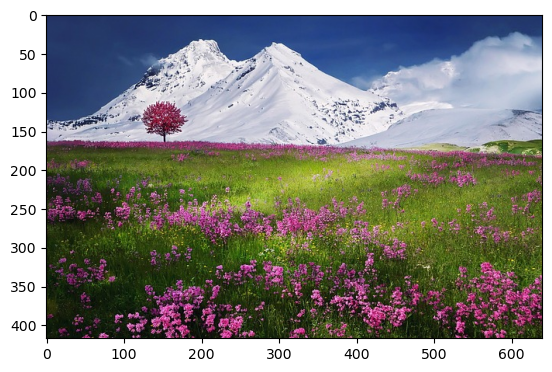

In [5]:
# get image from local storage
img = plt.imread('./data/mountains-736886_640.jpg')

# define dimensions
img_x = len(img)
img_y = len(img[0])
img_z = len(img[0][0])

# base image
plt.imshow(img)
plt.show()

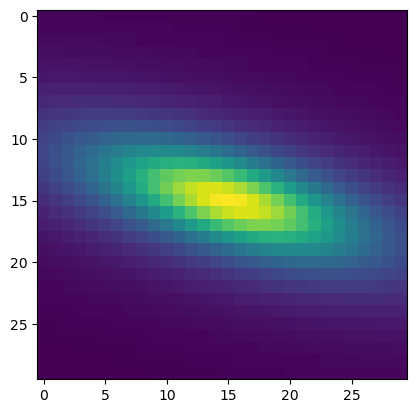

In [6]:
# generating a "shaky" blurred kernel using Moffat PSF
moffat_layer = moffat_blur(30, 30, 15, 15, 6, 14, 7, 2)
moffat_layer_scaled = moffat_layer / np.amax(moffat_layer) * 0.00675

plt.imshow(moffat_layer)
plt.show()

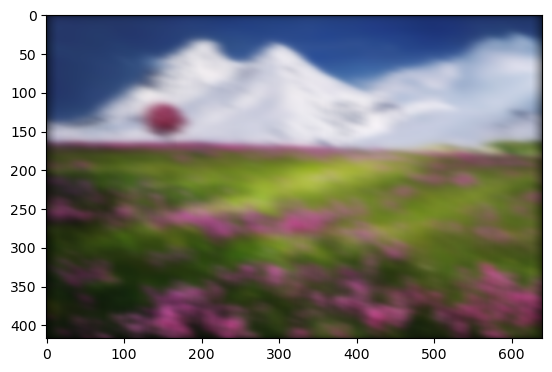

In [7]:
# apply Moffat kernel to orinal image
base_1 = conv_wrapper(img, img_x, img_y, img_z, moffat_layer_scaled)

plt.imshow(base_1)
plt.show()

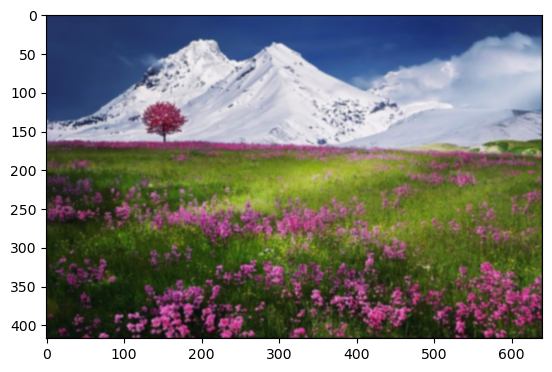

In [8]:
# referencing Gaussian portion of bloom filter (without bilinear interpolation)
# https://github.com/yoyoberenguer/BloomEffect
gaussian = np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]]) * (1/256)
base_2 = conv_wrapper(img, img_x, img_y, img_z, gaussian)

plt.imshow(np.uint8(base_2))
plt.show()

In [9]:
# # UNUSED due to brightness issues
# # 45/135-degree motion blur, referencing motion blur in C# desktop software
# # https://softwarebydefault.com/2013/06/09/image-blur-filters/
# motion_blur = np.array([[1,0,1,0,1],[0,1,0,1,0],[0,0,1,0,0],[0,1,0,1,0],[1,0,0,0,1]]) * (1/10)
# base_3 = conv_wrapper(img, img_x, img_y, img_z, motion_blur)

# plt.imshow(np.uint8(base_3))

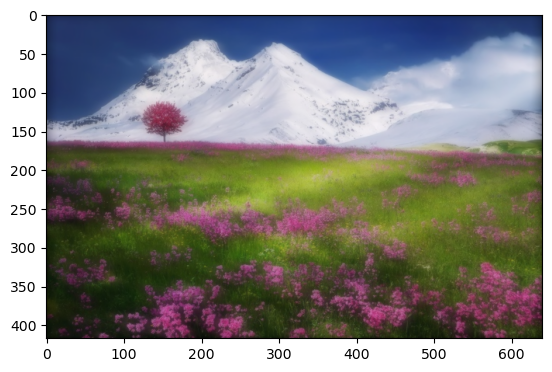

In [10]:
# combine images based on defined bias for weighted average
# original and moffat blur
combo_1 = weighted_blend(img, base_1, img_x, img_y, img_z, 0.75)
# prior combo and gaussian blur
combo_2 = weighted_blend(combo_1, base_2, img_x, img_y, img_z, 0.25)

plt.imshow(combo_2)
plt.show()

In [11]:
# use PIL to convert original image from RGB to RGBA
img_pil = Image.fromarray(img)
# set 25% transparency
img_pil.putalpha(63)

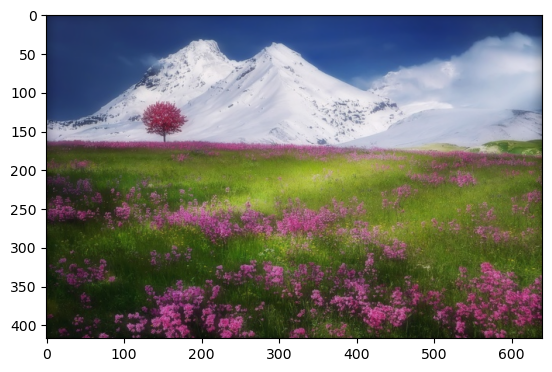

In [12]:
# use PIL to convert ensembled image from RGB to RGBA
combo_2_pil = Image.fromarray(combo_2)
# overlay original image on top of ensembled image
combo_2_pil.paste(img_pil, (0,0), mask=img_pil)
plt.imshow(combo_2_pil)

# save result
plt.imsave('./data/output.jpg', combo_2_pil / np.amax(combo_2_pil))

## Evaluation
In comparison to Yuan Chuan's lightweight SVG-based CSS methods, my implementation of "Dreamy Blur" isn't nearly as fast but still produces comparable results. Rather than using a single blurring filter and PNG RGBA image channel manipulation, I prefer ensembling Moffat and Gaussian blur kernels to mimic lens haze and anamorphic distortion. Weighted average image blending in lieu of layering transparencies forms a base image for blending back into the original image to absorb some definition that brings back a realistic look to the distorted clustering of images. The final product has three core attributes that I find interesting: haze, shine, and cloudiness. It's almost as if the picture were taken in front of a fireplace. There is one point I'd like to note: the compensation for lens perturbation would be a better point-of-approach had I used a dilation matrix to magnify the focus. This would have brought in a surrealist feel to the image, which is why I decided to eschew it.

An alternative approach (which I may try to implement later) would put image segmentation at the forefront of the implementation. Since such edges are defined as a set points, a single blurring function could be used in tandem with separate layers whose edges are smoothed-in using median or mean blurring and layered in solely as a transparency. This goes beyond the discussed article's concepts to instead create depth-based contouring via the image's constituent polygons. This would be useful for testing and improving image classification algorithms that rely on stochastic gradient descent, since the well-defined contours might throw off threshold measures.